In [23]:
import pandas as pd
import numpy as np

import category_encoders as ce
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import   (AdaBoostRegressor, 
                                ExtraTreesRegressor, 
                                GradientBoostingRegressor, 
                                RandomForestRegressor)

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Статистика

In [11]:
train.shape

(1460, 81)

In [12]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
train.isna().sum(axis=0).sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

## Визуализация 

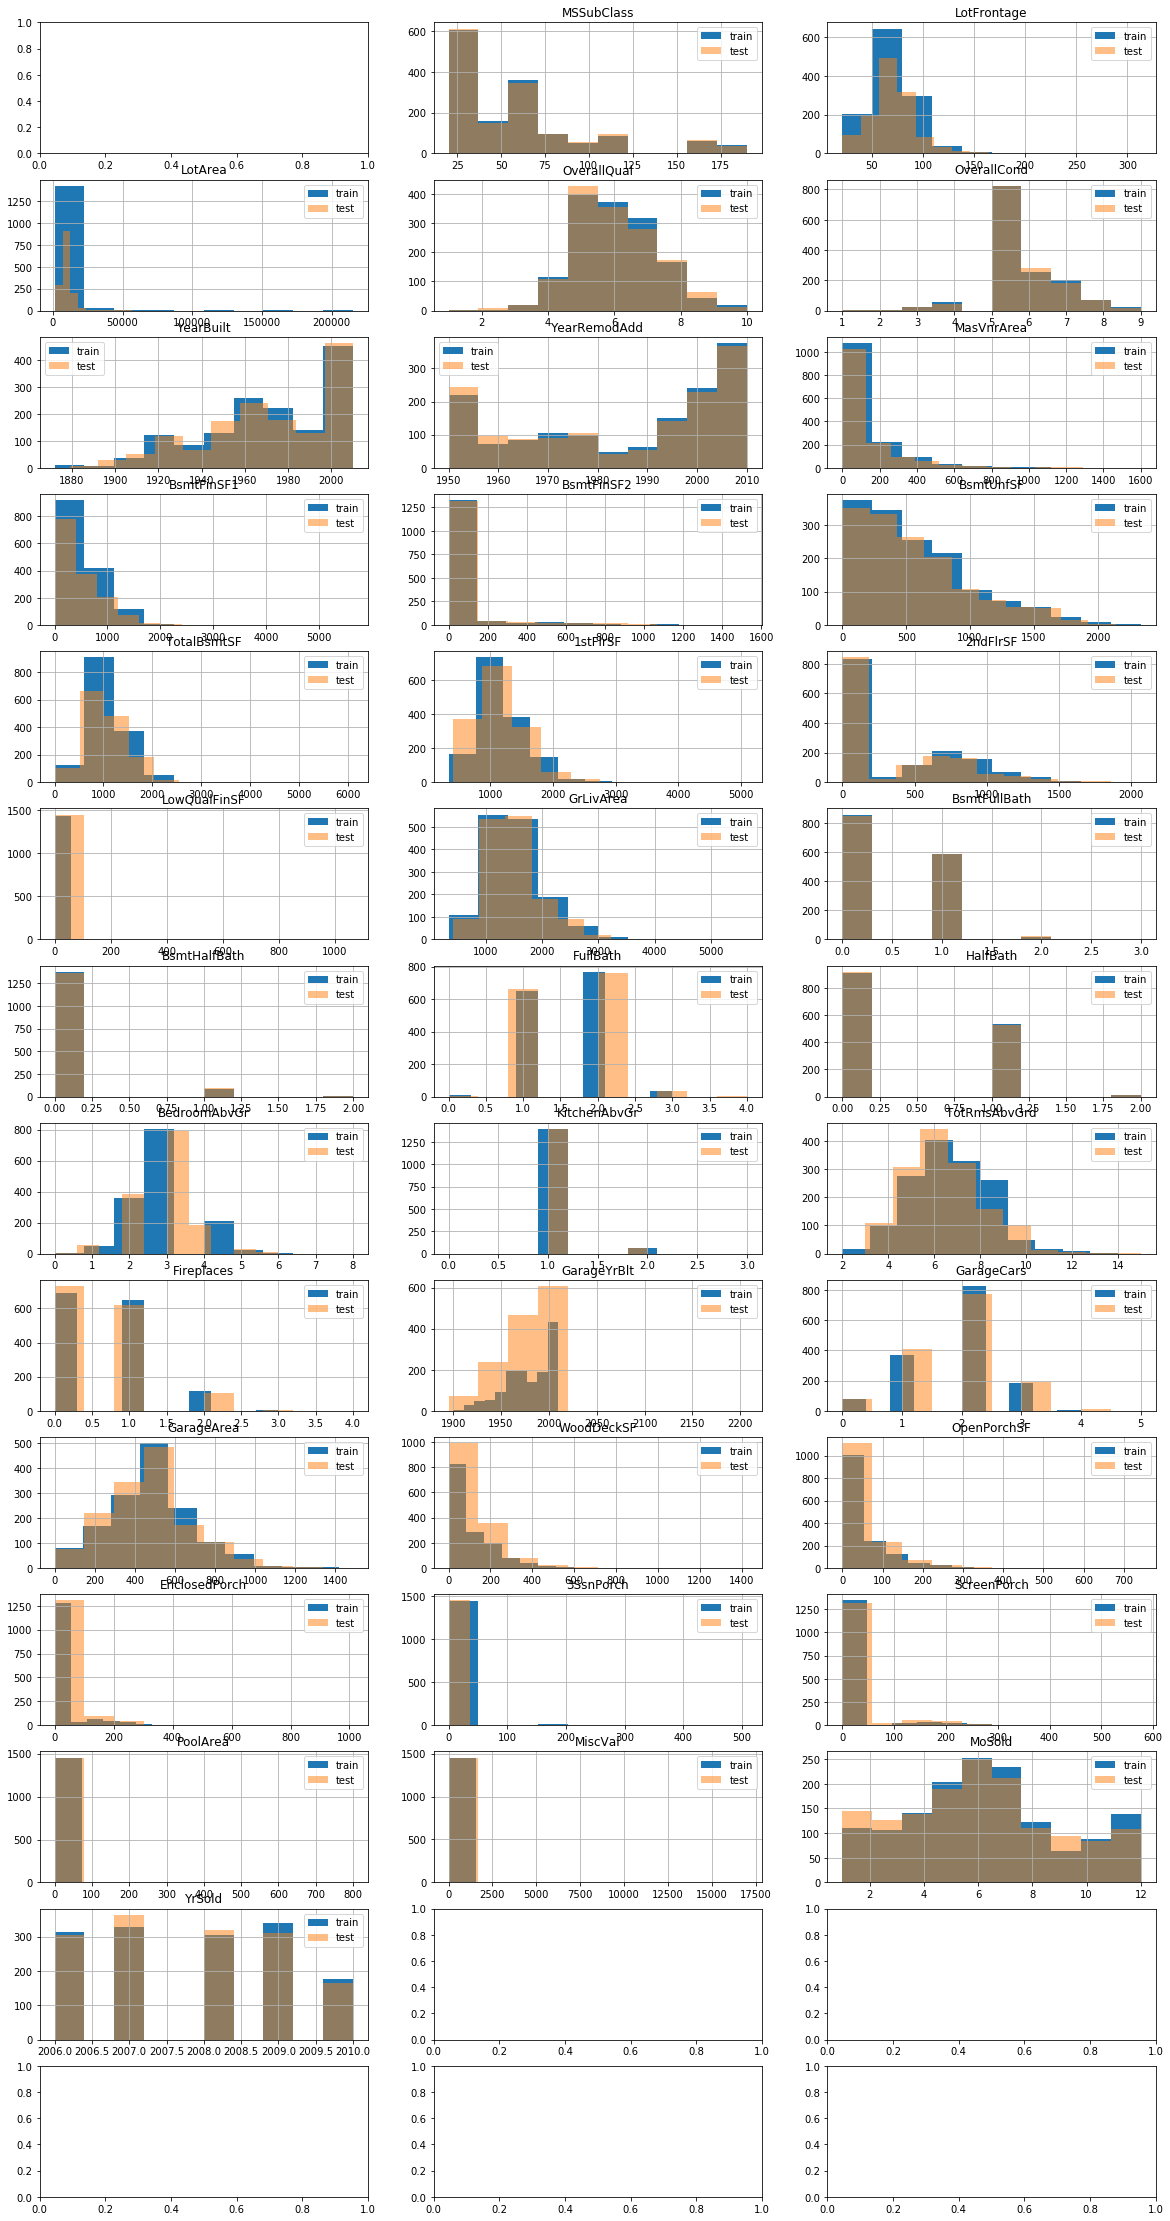

In [16]:
fig, axs = plt.subplots(14, 3, figsize=(20, 40))
for num, col in enumerate(train.select_dtypes([np.float64, np.int64]).columns):
    if col in test.columns and col != "Id":
        ax = axs.flatten()[num]
        ax = train[col].hist(label='train', ax=ax)
        test[col].hist(ax=ax, alpha=0.5, label='test')
        ax.legend()
        ax.set_title(col)

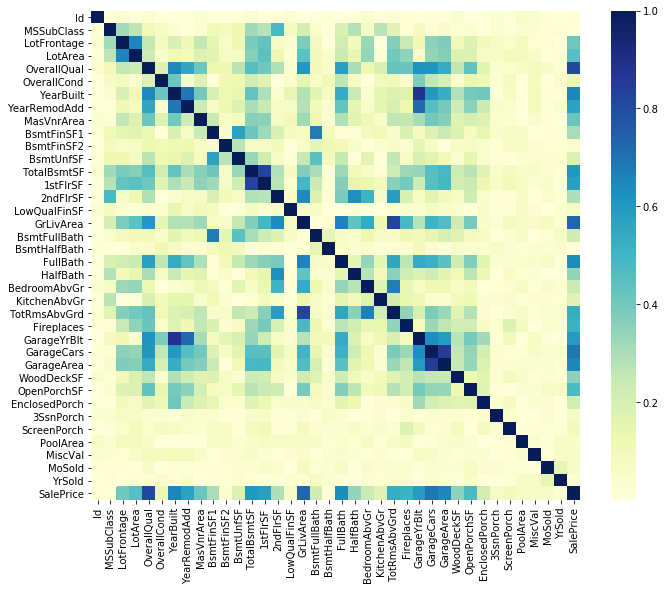

In [18]:
corr_matrix = train.corr(method='spearman').abs() 
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax=ax)

In [44]:
def prepare_dataset(train, test):
    train = train.copy(); test = test.copy()
    
    dataset = pd.concat([train, test], keys=['train', 'test'])
    dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']
    dataset.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
    
    ## удалим столбцы, где слишком много пропусков
    nans_dataset = dataset.isna().sum(axis=0).sort_values(ascending=False) / len(dataset)
    many_missing = list(nans_dataset[nans_dataset>0.15].index)
    dataset.drop(columns=many_missing, inplace=True)
    
    # заполняем пропуски
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        dataset[col] = dataset[col].fillna('No')
    
    for col in dataset.columns:
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
        else:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
            
            
    # стандартизация        
    num_cols = dataset.select_dtypes(['int64', 'float64']).columns
    dataset[num_cols] = StandardScaler().fit_transform(dataset[num_cols])

            
    train_features = dataset.loc['train']
    test_features = dataset.loc['test']
    
    # преобразуем категориальные переменные при помощи TargetEncoder
    ce_target = ce.TargetEncoder()
    train_features = ce_target.fit_transform(train_features, train['SalePrice'])
    test_features = ce_target.transform(test_features)
    
    
    return train_features, test_features
    
    

In [45]:
trainP, testP = prepare_dataset(train, test)

In [46]:
X = trainP
y = np.log(train['SalePrice'])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=200)

## Проверим несколько базовых моделей 

In [48]:
def get_score(preds, true, suff):    
    return {f'r2_{suff}': r2_score(preds, true),
            f'RMSE{suff}': np.sqrt(mean_squared_error(preds, true))}

def train_test(model, X_train, X_test, y_train, y_test):
    prediction_train = model.predict(X_train)
    print(model.__class__.__name__)
    prediction_test = model.predict(X_test)
    
    df = pd.DataFrame([{"model":  model.__class__.__name__,
                   **get_score(prediction_train, y_train, 'train'),
                   **get_score(prediction_test, y_test, 'test') 
                  }])
    print(df)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=200)

for model_class in (AdaBoostRegressor,
                    ExtraTreesRegressor,
                    GradientBoostingRegressor,
                    RandomForestRegressor):
    mod = model_class().fit(X_train, y_train)
    train_test(mod, X_train, X_test, y_train, y_test)
    print()
    

AdaBoostRegressor
               model  r2_train  RMSEtrain  r2_test  RMSEtest
0  AdaBoostRegressor    0.8552   0.144589  0.81238  0.170653

ExtraTreesRegressor
                 model  r2_train  RMSEtrain   r2_test  RMSEtest
0  ExtraTreesRegressor       1.0   0.000008  0.851099  0.152374

GradientBoostingRegressor
                       model  r2_train  RMSEtrain   r2_test  RMSEtest
0  GradientBoostingRegressor  0.955743    0.08048  0.879316  0.138156

RandomForestRegressor
                   model  r2_train  RMSEtrain   r2_test  RMSEtest
0  RandomForestRegressor  0.981868   0.051034  0.836305  0.157712



## Самым перспективным выглядит GradientBoostingRegressor

## Настроим гиперпараметры:

In [50]:
def rmse_sklearn(truth, predictions):
    return mean_squared_error(truth, predictions) ** 0.5

rmse_scorer = make_scorer(rmse_sklearn, greater_is_better=True, needs_proba=False)


In [63]:
def objective(params):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'learning_rate': params['learning_rate'],
             }
    
    gb = GradientBoostingRegressor(**params)
    score = cross_val_score(gb, X, y, scoring=rmse_scorer, cv=5).mean()
    print("RMSE {:.3f} params {}".format(score, params))
    return score

space_gb = {
    'n_estimators': hp.quniform('n_estimators', 200, 400, 25),
    'max_depth': hp.quniform('max_depth', 2, 5, 1),
    'max_features': hp.quniform('max_features', 0.3, 0.6, 0.05),
    'learning_rate': hp.quniform('learning_rate', 0.04, 0.06, 0.005)
}

best = fmin(fn=objective,
            space=space_gb,
            algo=tpe.suggest,
            max_evals=20)

RMSE 0.121 params {'n_estimators': 400, 'max_depth': 4, 'max_features': 0.45, 'learning_rate': 0.055}                  
RMSE 0.120 params {'n_estimators': 325, 'max_depth': 4, 'max_features': 0.4, 'learning_rate': 0.04}                    
RMSE 0.119 params {'n_estimators': 325, 'max_depth': 3, 'max_features': 0.45, 'learning_rate': 0.045}                  
RMSE 0.119 params {'n_estimators': 225, 'max_depth': 3, 'max_features': 0.5, 'learning_rate': 0.045}                   
RMSE 0.119 params {'n_estimators': 275, 'max_depth': 3, 'max_features': 0.35000000000000003, 'learning_rate': 0.05}    
RMSE 0.121 params {'n_estimators': 400, 'max_depth': 4, 'max_features': 0.55, 'learning_rate': 0.05}                   
RMSE 0.123 params {'n_estimators': 225, 'max_depth': 5, 'max_features': 0.55, 'learning_rate': 0.05}                   
RMSE 0.118 params {'n_estimators': 300, 'max_depth': 4, 'max_features': 0.4, 'learning_rate': 0.04}                    
RMSE 0.124 params {'n_estimators': 225, 

In [56]:
# лучшие параметры
best

{'learning_rate': 0.04,
 'max_depth': 4.0,
 'max_features': 0.30000000000000004,
 'n_estimators': 350.0}

In [59]:
gb = GradientBoostingRegressor(learning_rate=0.04, max_depth=4, max_features=0.3, n_estimators=350)
res = cross_val_score(gb, X, y, cv=5, scoring='neg_root_mean_squared_error')
-res.mean(), res.std()

(0.11776147695326049, 0.008811040434457313)

## Проверили, убедились при помощи кросс-валидации в устойчивости результатов
## Значение RMSE устойчиво на 0.12

In [123]:
gb = GradientBoostingRegressor(learning_rate=0.055, max_depth=4, max_features=0.45, n_estimators=275)
gb.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.055, loss='ls',
                          max_depth=4, max_features=0.45, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=275,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [126]:
predictions = gb.predict(testP)
test_id = test['Id']
pd.DataFrame({"Id": test_id, "SalePrice": predictions}).to_csv('predict.csv', index=False)

,Id,SalePrice
0,1461,11.747200
1,1462,11.954555
2,1463,12.136963
3,1464,12.187330
4,1465,12.121676
...,...,...
1454,2915,11.317331
1455,2916,11.312771
1456,2917,11.876905
1457,2918,11.639927
